In [1]:
import numpy as np
import lDGA.config as cfg
import lDGA.dmft_reader as dmft_reader
import lDGA.bse as bse
import lDGA.utilities as util
import matplotlib.pyplot as plt
import correl.w2dyn_post as w5
import correl.plotting as cpl
import h5py as h5
from numba import jit

In [2]:
##### LATTICE UTILITIES #####

@jit(nopython=True)
def ik2k(ik:int, dim:int, Nk:int) -> np.ndarray:
    k = np.zeros(dim, dtype=np.float64)
    ikres=ik*1
    for idim in range(dim):
        ik_dim = ikres % Nk
        k[idim] = np.pi*(-1.0 + 2.0*ik_dim/Nk)
        ikres = ikres // Nk
    return k

@jit(nopython=True)
def k2ik(k:np.ndarray, Nk:int) -> int:
    dim = len(k)
    ik = 0
    for idim in range(dim):
        ik += int(np.round((Nk*k[idim]/(2.0*np.pi) + 0.5*Nk))) % Nk * Nk**idim
    return int(ik)

@jit(nopython=True)
def wrap_k(k:np.ndarray) -> np.ndarray:
    for i in range(len(k)):
        while k[i] < -np.pi:
            k[i] += 2 * np.pi
        while k[i] >= np.pi:
            k[i] -= 2 * np.pi
    return k

@jit(nopython=True)
def irr_q_grid(qpoints):
    nq = len(qpoints)

    q_grid = []
    weights = []
    for ix in range(1,nq+1):
        a = 1
        if (ix==1 or ix==nq):
            a *= 0.5
        for iy in range(1,ix+1):
            b = a
            if (iy==1 or iy==nq):
                b *= 0.5
            b *= 2//((iy)//(ix) + 1)
            weights.append(b)
            qx = qpoints[ix-1]
            qy = qpoints[iy-1]
            q_grid.append([qx, qy])

    q_grid = np.array(q_grid)
    weights = np.array(weights)

    return q_grid, weights

'''@jit(nopython=True)
def irr_q_grid(qpoints):
    q_grid = []
    weights = []
    nq = len(qpoints)

    for ix in range(1,nq + 1):
        qx = qpoints[ix-1]
        for iy in range(1,ix + 1):  # only qy ≤ qx for irreducible triangle
            qy = qpoints[iy-1]

            weight = 1.0

            # Boundary reductions (trapezoidal rule)
            if ix == 1 or ix == nq:
                weight *= 0.5
            if iy == 1 or iy == nq:
                weight *= 0.5
            if ix == iy and ix != 1 and ix != nq:
                weight *= 0.5  # Diagonal line qx = qy is a symmetry boundary

            q_grid.append([qx, qy])
            weights.append(weight)

    return np.array(q_grid), np.array(weights)'''

@jit(nopython=True)
def chi0_w_q(beta:float, mu:float, s_dmft:np.ndarray, k_grid:np.ndarray, weights:np.ndarray, qpoints: np.ndarray, n4iwf:int, n4iwb:int, ts=None, s_dga:np.ndarray=None) -> np.ndarray:
    '''
    Compute lattice bubble chi0 for all iw and range of q-points
    '''
    nk = k_grid.shape[0]
    niwf  = s_dmft.shape[0]//2
    chi0_wq = np.zeros((2*n4iwf,2*n4iwb+1,qpoints.shape[0]), dtype=np.complex128)

    if(ts is None):
        t1=1.0; t2=0.0
    else:
        t1=ts[0]; t2=ts[1]
    

    nu_array=util.build_nu_mats(n4iwf, beta)
    for inu,nu in enumerate(nu_array):
        for ik,k in enumerate(k_grid):
            G_nuw_kq = util.G_wq_given_nuk(nu,k,s_dmft,n4iwb,qpoints,beta,mu,s_dga)
            if(s_dga is None):
                G_nu_k = 1.0/(1j*nu - util.ek_2d(k,t=t1,tpr=t2) + mu - s_dmft[inu-n4iwf+niwf] )
            else:
                G_nu_k = 1.0/(1j*nu - util.ek_2d(k, t=t1,tpr=t2) + mu - s_dga[inu,ik] )
            chi0_wq[inu,:,:] += G_nu_k*G_nuw_kq *weights[ik]
    chi0_wq *= -beta/np.sum(weights)
    return chi0_wq

In [15]:
nq = 4
nk0 = 2*nq-2
qpoints = np.linspace(0,np.pi,nq,endpoint=True)
qpoints_full = np.linspace(-np.pi,np.pi,nk0,endpoint=False)
q_grid, weights = irr_q_grid(qpoints)

q = np.linspace(-np.pi,np.pi,nk0,endpoint=False)
q_grid_full = np.meshgrid(q,q)
q_grid_full = np.array(q_grid_full).reshape(2,-1).T

print(q_grid, weights)
print(q_grid_full)


[[0.         0.        ]
 [1.04719755 0.        ]
 [1.04719755 1.04719755]
 [2.0943951  0.        ]
 [2.0943951  1.04719755]
 [2.0943951  2.0943951 ]
 [3.14159265 0.        ]
 [3.14159265 1.04719755]
 [3.14159265 2.0943951 ]
 [3.14159265 3.14159265]] [0.25 1.   1.   1.   2.   1.   0.5  1.   1.   0.25]
[[-3.14159265 -3.14159265]
 [-2.0943951  -3.14159265]
 [-1.04719755 -3.14159265]
 [ 0.         -3.14159265]
 [ 1.04719755 -3.14159265]
 [ 2.0943951  -3.14159265]
 [-3.14159265 -2.0943951 ]
 [-2.0943951  -2.0943951 ]
 [-1.04719755 -2.0943951 ]
 [ 0.         -2.0943951 ]
 [ 1.04719755 -2.0943951 ]
 [ 2.0943951  -2.0943951 ]
 [-3.14159265 -1.04719755]
 [-2.0943951  -1.04719755]
 [-1.04719755 -1.04719755]
 [ 0.         -1.04719755]
 [ 1.04719755 -1.04719755]
 [ 2.0943951  -1.04719755]
 [-3.14159265  0.        ]
 [-2.0943951   0.        ]
 [-1.04719755  0.        ]
 [ 0.          0.        ]
 [ 1.04719755  0.        ]
 [ 2.0943951   0.        ]
 [-3.14159265  1.04719755]
 [-2.0943951   1.04719

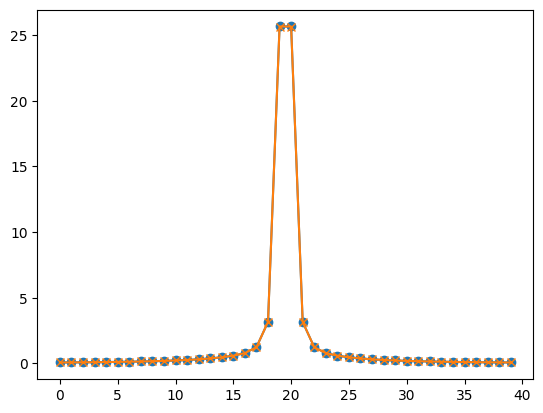

In [12]:
iw = 0

data = w5.read("gsq0_0_w1_n0_95_2p-2025-03-22-Sat-17-25-49.hdf5")
chi0 = data.bubble_q(w5.ek(kpoints=nk0, t=1), w5.ek(kpoints=nk0, t=1), biw=iw)

dmft_file = "gsq0_0_w1_n0_95_2p-2025-03-22-Sat-17-25-49.hdf5"
dga_cfg = cfg.DGA_Config(dmft_file)
reader = dmft_reader.DMFT_Reader(dga_cfg)

beta = dga_cfg.dmft_dict['beta']
mu = dga_cfg.dmft_dict['mu']
U = dga_cfg.dmft_dict['U']
g = dga_cfg.dmft_dict['giw']
s = dga_cfg.dmft_dict['siw']
g2 = dga_cfg.dmft_dict['chi_ph']
niwf = dga_cfg.niwf
n4iwf = dga_cfg.n4iwf
n4iwb = dga_cfg.n4iwb
kdim = dga_cfg.kdim
nk = 96
g0 = 100**(0.5) #dga_cfg.dmft_dict['g0']
w0 = 100 #dga_cfg.dmft_dict['w0']
n = dga_cfg.dmft_dict['occ']

chi0_irr = chi0_w_q(beta, mu, s, q_grid, weights, np.array([[0,0]]), n4iwf, n4iwb)

plt.plot(chi0[n4iwf-20:n4iwf+20], "o-")
plt.plot(chi0_irr[n4iwf-20:n4iwf+20,n4iwb+iw,0], "x-")

In [34]:
util.generate_sym(np.array([1.,2.]))

array([[ 1.,  2.],
       [-2.,  1.],
       [-1., -2.],
       [ 2., -1.],
       [ 1., -2.],
       [-1.,  2.],
       [ 2.,  1.],
       [-2., -1.]])

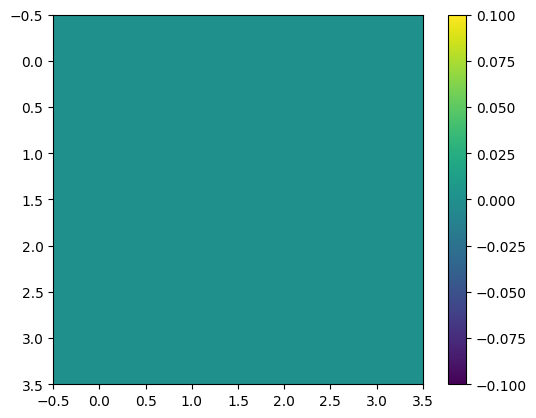

In [4]:
dga_dat = h5.File("../src/lDGA/results_2025-05-30_15:07:28.h5")
chi_d = dga_dat['iter_2/chi_d_latt'][()][50]
chi_m = dga_dat['iter_0/chi_d_latt'][()][50]

plt.imshow((chi_m-chi_d).real.reshape(4,4))
plt.colorbar()

In [3]:
dga_dat = h5.File("../src/lDGA/results_2025-06-06_13:22:56.h5")
sigs = []
mus = []
lambdas = []
for iter in range(10):
    try:
        mu = dga_dat[f'iter_{iter}/mu'][()]
        sig = dga_dat[f'iter_{iter}/sigma'][()]
        lam = dga_dat[f'iter_{iter}/lambda_m'][()]
    except KeyError:
        continue
    sig = np.sum(sig, axis=-1)/sig.shape[-1]
    sigs.append(sig)
    mus.append(mu)
    lambdas.append(lam)

In [4]:
lam_full = 0.05449049
lam = 0.06444376

In [5]:
qpoints = np.linspace(0,np.pi,3)
q_grid, weights = util.irr_q_grid(qpoints)

chi_m_q = dga_dat[f'iter_0/chi_m_latt'][()]
dga_dat.close()
dga_dat_full = h5.File("../src/lDGA/results_2025-06-06_13:25:20.h5")
chi_m_full = dga_dat_full[f'iter_0/chi_m_latt'][()]
print(chi_m_full.shape)


chi_m = chi_m_q@weights/np.sum(weights)

chi_m_lam =  chi_m_q/(1 + lam*chi_m_q)
chi_m_lam = chi_m_lam@weights/np.sum(weights)

chi_m_lam_full =  chi_m_q/(1 + lam_full*chi_m_q)
chi_m_lam_full = chi_m_lam_full@weights/np.sum(weights)

nu_range = slice(50-5,50+6)
plt.plot(chi_m[nu_range], "-")
plt.plot(chi_m_lam[nu_range], "o-")
plt.plot(chi_m_lam_full[nu_range], "x--")


AttributeError: module 'lDGA.utilities' has no attribute 'irr_q_grid'

0.284031


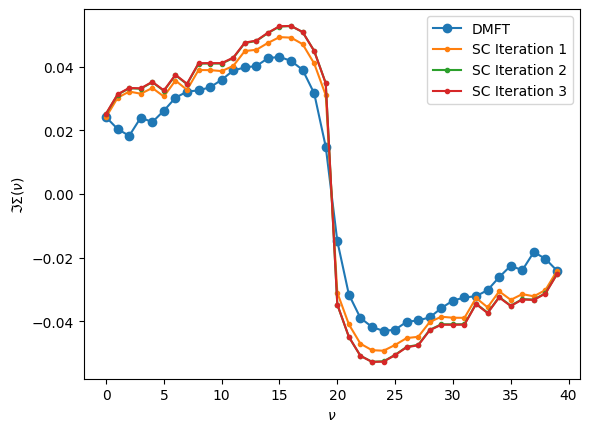

In [54]:
data = w5.read("gsq0_0_w1_n0_95_2p-2025-03-22-Sat-17-25-49.hdf5")
print(data.mu)

siw = data.siw()[0,0,:]

plt.plot(siw[1000-20:1000+20].imag, "o-", label="DMFT")
for i,sig in enumerate(sigs, start=1):
    plt.plot(sig[sig.shape[0]//2-20:sig.shape[0]//2+20].imag, ".-", label=f"SC Iteration {i}")
plt.legend()
plt.xlabel(r"$\nu$")
plt.ylabel(r"$\Im \Sigma(\nu)$")
plt.savefig("SC_DGA_se_2.pdf")

### load dmft data

In [50]:
# example file
#dmft_file = "gsq0_0_w1_n0_95_2p-2025-03-22-Sat-17-25-49.hdf5"
dmft_file = "lam1_aal_hf_u12_2p-2025-04-28-Mon-21-05-08.hdf5"
dga_cfg = cfg.DGA_Config(dmft_file)
reader = dmft_reader.DMFT_Reader(dga_cfg)

beta = dga_cfg.dmft_dict['beta']
mu = dga_cfg.dmft_dict['mu']
U = dga_cfg.dmft_dict['U']
g = dga_cfg.dmft_dict['giw']
s = dga_cfg.dmft_dict['siw']
g2 = dga_cfg.dmft_dict['chi_ph']
niwf = dga_cfg.niwf
n4iwf = dga_cfg.n4iwf
n4iwb = dga_cfg.n4iwb
kdim = dga_cfg.kdim
nk = 96

In [51]:
g0 = 100**(0.5) #dga_cfg.dmft_dict['g0']
w0 = 100 #dga_cfg.dmft_dict['w0']
n = dga_cfg.dmft_dict['occ']
beta

np.float64(10.0)

/Users/eminmoghadas/anaconda3/envs/dga_dev/lib/python3.13/site-packages/matplotlib/cbook.py:1709: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/eminmoghadas/anaconda3/envs/dga_dev/lib/python3.13/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


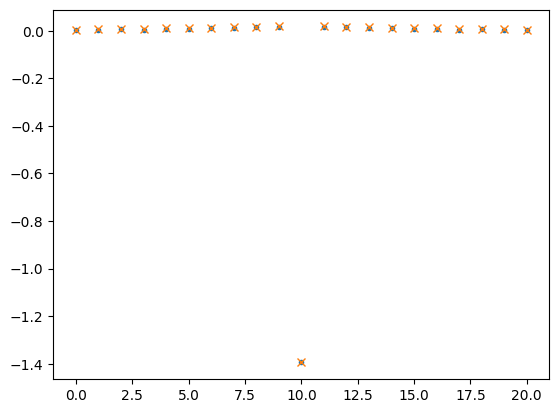

In [52]:
data = w5.read("lam1_aal_hf_u12_2p-2025-04-28-Mon-21-05-08.hdf5")
chi_w = []
chi_w_asymp = []
v_w = []
for iw in range(-10,11):
    chi = data.bse_ph(w5.ek(t=1), w5.ek(t=1, q=[np.pi, np.pi]), "s", biw=iw)
    chi_w.append(np.sum(chi)/data.beta**2)
    chi_w_asymp.append(np.sum(chi)/data.beta**2 + w5.asymp_chi(2*n4iwf, data.beta))
    chi0_q = data.bubble_q(w5.ek(t=1), w5.ek(t=1, q=[np.pi, np.pi]),biw=iw)
    v = np.sum(np.diag(1/(chi0_q))@chi, axis=1)/(1+U*(np.sum(chi)/data.beta**2 + w5.asymp_chi(2*n4iwf, data.beta)))
    v_w.append(v)

plt.plot(chi_w, ".")
plt.plot(chi_w_asymp, "x")

### gamma asymp

In [53]:
@jit(nopython=True)
def chi0_loc_w_full(beta: float, g:np.ndarray, n4iwf:int, n4iwb:int, nouter) -> np.ndarray:
    '''
    Compute local bubble for all iw
    '''
    chi0_w = np.empty((2*nouter,2*n4iwb+1), dtype=np.complex128)
    for w_idx, iw in enumerate(range(-n4iwb,n4iwb+1)):
        if iw>0:
            g_nu = g[iw:-iw]
            g_nu_omega = g[2*iw:]
        elif iw<0:
            g_nu = g[abs(iw):-abs(iw)]
            g_nu_omega = g[:-2*abs(iw)]
        else:
            g_nu = g
            g_nu_omega = g
        chi0 = -beta*g_nu*g_nu_omega
        nu_range = slice(chi0.shape[0]//2-nouter,chi0.shape[0]//2+nouter)
        chi0_w[...,w_idx] = chi0[nu_range]
    return chi0_w

@jit(nopython=True)
def gamma_w(beta, U, w0, g0, chi0_w, chi, n4iwf, n4iwb, nouter):
    chi_d = chi[0,...] + chi[1,...]
    chi_m = chi[0,...] - chi[1,...]
    gamma_d = np.empty((2*n4iwf, 2*n4iwf, 2*n4iwb+1), dtype=np.complex128)
    gamma_m = np.empty((2*n4iwf, 2*n4iwf, 2*n4iwb+1), dtype=np.complex128)
    nu_mats = util.build_nu_mats(nouter, beta)
    w_mats = util.build_w_mats(n4iwb, beta)
    for w_idx, iw in enumerate(range(-n4iwb,n4iwb+1)):
        Uw = util.Udyn(w_mats[w_idx], w0, g0, U)
        Uw_array = np.ones((2*nouter, 2*nouter))*Uw
        Unu = util.U_trans(nu_mats, nu_mats, w0, g0, U)
        U_d = 2*Uw_array - Unu
        U_m = -Unu
        
        chi_t_d = np.linalg.inv(np.diag(1/chi0_w[:,w_idx]) + U_d/beta**2)
        chi_t_m = np.linalg.inv(np.diag(1/chi0_w[:,w_idx]) + U_m/beta**2)

        nu_range = slice(nouter-n4iwf,nouter+n4iwf)

        dgamma_d = beta**2*(np.linalg.inv(chi_d[:,:,w_idx]) - np.linalg.inv(chi_t_d[nu_range, nu_range]))
        dgamma_m = beta**2*(np.linalg.inv(chi_m[:,:,w_idx]) - np.linalg.inv(chi_t_m[nu_range, nu_range]))

        gamma_d[:,:,w_idx] = dgamma_d + U_d[nu_range, nu_range]
        gamma_m[:,:,w_idx] = dgamma_m + U_m[nu_range, nu_range]

    return gamma_d, gamma_m

@jit(nopython=True)
def gamma_w_small(chi0_w, chi, n4iwf, n4iwb, niw):
    chi_d = chi[0,...] + chi[1,...]
    chi_m = chi[0,...] - chi[1,...]
    gamma_d = np.empty((2*niw, 2*niw, 2*n4iwb+1), dtype=np.complex128)
    gamma_m = np.empty((2*niw, 2*niw, 2*n4iwb+1), dtype=np.complex128)
    for w_idx, iw in enumerate(range(-n4iwb,n4iwb+1)):
        gamma_d[:,:,w_idx] = beta**2*(np.linalg.inv(chi_d[n4iwf-niw:n4iwf+niw,n4iwf-niw:n4iwf+niw,w_idx]) - np.diag(1/chi0_w[:,w_idx]))
        gamma_m[:,:,w_idx] = beta**2*(np.linalg.inv(chi_m[n4iwf-niw:n4iwf+niw,n4iwf-niw:n4iwf+niw,w_idx]) - np.diag(1/chi0_w[:,w_idx]))

    return gamma_d, gamma_m

@jit(nopython=True)
def bse_asymp(beta:float, u:np.float64, omega0:np.float64, g:np.float64, chi0_w_full:np.ndarray, chi0_w_q:np.ndarray, dgamma_d:np.ndarray, dgamma_m:np.ndarray, niwf:int, n4iwf:int, n4iwb:int, qpoints:np.ndarray):

    chi_d_w_q  = np.empty((2*n4iwb+1, qpoints.shape[0]), dtype=np.complex128)
    v_d_w_q    = np.empty((2*n4iwf, 2*n4iwb+1, qpoints.shape[0]), dtype=np.complex128)
    A_d_w_q = np.empty((2*n4iwf, 2*n4iwb+1, qpoints.shape[0]), dtype=np.complex128)
    
    chi_m_w_q  = np.empty((2*n4iwb+1, qpoints.shape[0]), dtype=np.complex128)
    v_m_w_q    = np.empty((2*n4iwf, 2*n4iwb+1, qpoints.shape[0]), dtype=np.complex128)
    A_m_w_q = np.empty((2*n4iwf, 2*n4iwb+1, qpoints.shape[0]), dtype=np.complex128)
    
    numats = util.build_nu_mats(n4iwf,beta)
    wmats  = util.build_w_mats(n4iwb,beta)

    Uw = util.Udyn_arr(wmats,omega0,g,u).astype(np.complex128)
    Ununup = util.U_trans(nu=numats,nup=numats, omega0=omega0, g=g, u=u).astype(np.complex128)

    u_d = 2*Uw - u
    u_m = -u

    for q_idx, q in enumerate(qpoints):
        for w_idx, iw in enumerate(range(-n4iwb, n4iwb+1)):
            phi_d = np.linalg.inv(np.diag(1/chi0_w_q[:,w_idx,q_idx]) + (dgamma_d[:,:,w_idx]-u_d[w_idx]*np.ones((2*n4iwf,2*n4iwf), dtype=np.complex128))/beta**2)
            phi_m = np.linalg.inv(np.diag(1/chi0_w_q[:,w_idx,q_idx]) + (dgamma_m[:,:,w_idx]-u_m*np.ones((2*n4iwf,2*n4iwf), dtype=np.complex128))/beta**2)

            bub_sum = (np.sum(chi0_w_full[niwf+n4iwf:, w_idx]) + np.sum(chi0_w_full[:niwf-n4iwf, w_idx])) / beta**2

            chi_d = 1/(1/(np.sum(phi_d)/beta**2 + bub_sum) + u_d[w_idx]) 
            chi_m = 1/(1/(np.sum(phi_m)/beta**2 + bub_sum) + u_m)

            v_d = np.sum(np.diag(1/chi0_w_q[:,w_idx,q_idx])@phi_d, axis=1) * (1-u_d[w_idx]*chi_d)/(1-u_d[w_idx]*(chi_d+bse.asymp_chi(2*niwf, beta)))
            v_m = np.sum(np.diag(1/chi0_w_q[:,w_idx,q_idx])@phi_m, axis=1) * (1-u_m*chi_m)/(1-u_m*(chi_m+bse.asymp_chi(2*niwf, beta)))

            one = np.ones((2*n4iwf,2*n4iwf), dtype=np.complex128)
            phi_d = phi_d - phi_d@(u_d[w_idx]*one)@phi_d*(1-u_d[w_idx]*chi_d) + phi_d@(u_d[w_idx]*one)@phi_d*(1-u_d[w_idx]*chi_d)**2/(1-u_d[w_idx]*(chi_d+bse.asymp_chi(2*niwf, beta)))
            phi_m = phi_m - phi_m@(u_m*one)@phi_m*(1-u_m*chi_m) + phi_m@(u_m*one)@phi_m*(1-u_m*chi_m)**2/(1-u_m*(chi_m+bse.asymp_chi(2*niwf, beta)))

            chi_d_w_q[w_idx,q_idx] = chi_d + bse.asymp_chi(2*niwf, beta)
            v_d_w_q[:,w_idx,q_idx] = v_d

            chi_m_w_q[w_idx,q_idx] = chi_m + bse.asymp_chi(2*niwf, beta)
            v_m_w_q[:,w_idx,q_idx] = v_m

    return chi_d_w_q, v_d_w_q, chi_m_w_q, v_m_w_q

In [54]:
nouter = 300

chi0_w_full = chi0_loc_w_full(beta, g, n4iwf, n4iwb, nouter)
dgamma_d, dgamma_m = gamma_w(beta, U, w0, g0, chi0_w_full, g2, n4iwf, n4iwb, nouter)

# kgrid has to be initialized beforehand
kpoints = np.linspace(-np.pi,np.pi,48,endpoint=False)
k_grid = np.meshgrid(kpoints,kpoints)
k_grid = np.array(k_grid).reshape(2,-1).T

chi0_q_w = bse.chi0_w_q(beta, mu, s, k_grid, np.array([[np.pi, np.pi]]), n4iwf, n4iwb)

chi_d, v_d, chi_m, v_m = bse_asymp(beta, U, w0, g0, chi0_w_full, chi0_q_w, dgamma_d, dgamma_m, nouter, n4iwf, n4iwb, np.array([[np.pi, np.pi]]))

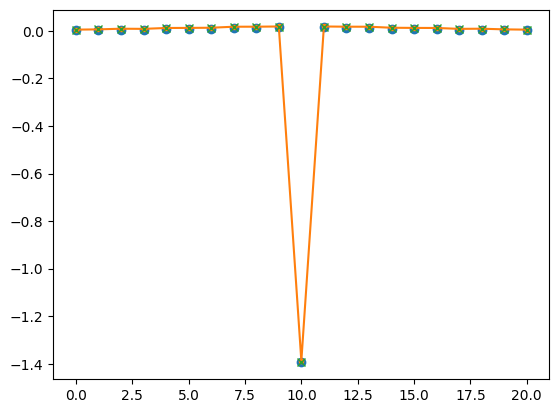

In [61]:
plt.plot(chi_w, "o")
plt.plot(chi_m[n4iwb-10:n4iwb+11,0], ".-")
plt.plot(chi_w_asymp, "x")

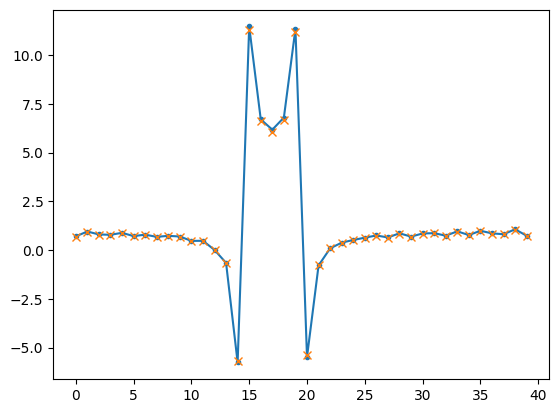

In [60]:
niw = 20
plt.plot(v_m[n4iwf-niw:n4iwf+niw,n4iwb+5,0], ".-")
plt.plot(v_w[15][n4iwf-niw:n4iwf+niw], "x")

# Test local chi

# delta_tau = 0.4


/Users/eminmoghadas/anaconda3/envs/dga_dev/lib/python3.13/site-packages/matplotlib/cbook.py:1709: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/eminmoghadas/anaconda3/envs/dga_dev/lib/python3.13/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


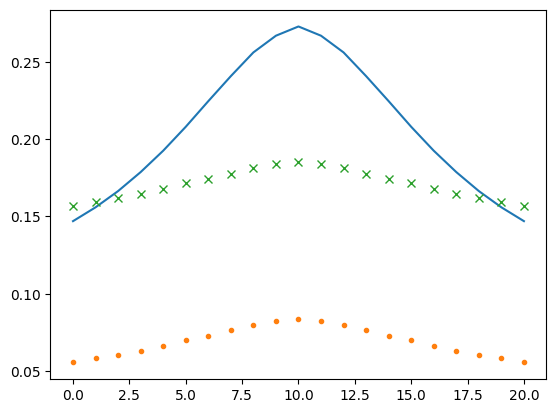

In [20]:
data_susz = w5.read("b400_u4_hf_lamb0_36_susz-2025-02-07-Fri-01-22-56.hdf5")
chi_imp_d, chi_imp_m = data_susz.chi_loc_phys(10)

data = w5.read("b400_u4_hf_lamb0_36_g2-2025-02-04-Tue-23-41-42.hdf5")
chi_w = []
chi_w_asymp = []
for iw in range(-10,11):
    chi = data.chi_ph(biw=iw).c
    n4iwf = chi.shape[0]
    chi_w.append(np.sum(chi)/data.beta**2)
    chi_w_asymp.append(np.sum(chi)/data.beta**2 + w5.asymp_chi(2*n4iwf, data.beta))

plt.plot(chi_imp_d)
plt.plot(chi_w, ".")
plt.plot(chi_w_asymp, "x")

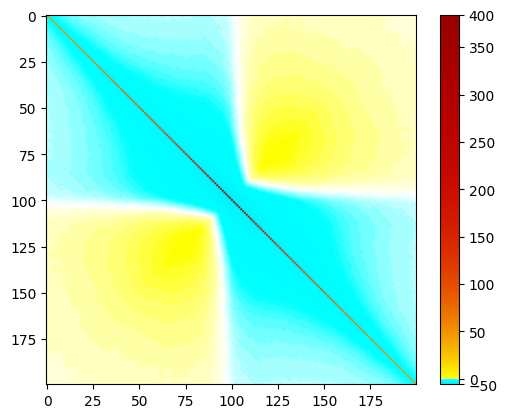

In [21]:
chi = data.chi_ph(biw=0).c

plt.imshow(chi.real, cmap=cpl.cmap_w(), norm=cpl.norm(chi.real))
plt.colorbar()

In [22]:
# example file
dmft_file = "b400_u4_hf_lamb0_36_g2-2025-02-04-Tue-23-41-42.hdf5"
#dmft_file = "lam1_aal_hf_u12_2p-2025-04-28-Mon-21-05-08.hdf5"
dga_cfg = cfg.DGA_Config(dmft_file)
reader = dmft_reader.DMFT_Reader(dga_cfg)

beta = dga_cfg.dmft_dict['beta']
mu = dga_cfg.dmft_dict['mu']
U = dga_cfg.dmft_dict['U']
g = dga_cfg.dmft_dict['giw']
s = dga_cfg.dmft_dict['siw']
g2 = dga_cfg.dmft_dict['chi_ph']
niwf = dga_cfg.niwf
n4iwf = dga_cfg.n4iwf
n4iwb = dga_cfg.n4iwb
kdim = dga_cfg.kdim
nk = 96
g0 = 0.6 #dga_cfg.dmft_dict['g0']
w0 = 0.2 #dga_cfg.dmft_dict['w0']
n = dga_cfg.dmft_dict['occ']


nouter = 300

chi0_w_full = chi0_loc_w_full(beta, g, n4iwf, n4iwb, nouter)

#dgamma_d, dgamma_m = gamma_w_small(chi0_w_full[nouter-n4iwf:nouter+n4iwf,:], g2, n4iwf, n4iwb, n4iwf)
dgamma_d, dgamma_m = gamma_w(beta, U, w0, g0, chi0_w_full, g2, n4iwf, n4iwb, nouter)

chi0_q_w = chi0_w_full[nouter-n4iwf:nouter+n4iwf, :].reshape((2*n4iwf, 2*n4iwb+1, 1))

chi_d, chi_m = bse_asymp(beta, U, w0, g0, chi0_w_full, chi0_q_w, dgamma_d, dgamma_m, nouter, n4iwf, n4iwb, np.array([[np.pi, np.pi]]))

NameError: name 'chi0_loc_w_full' is not defined

/Users/eminmoghadas/anaconda3/envs/dga_dev/lib/python3.13/site-packages/matplotlib/cbook.py:1709: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/eminmoghadas/anaconda3/envs/dga_dev/lib/python3.13/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


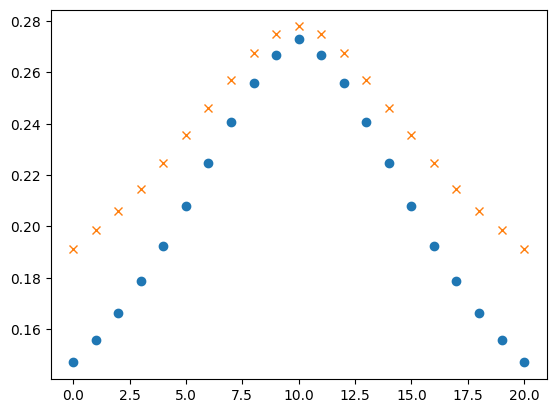

In [ ]:
plt.plot(chi_imp_d, "o")
plt.plot(chi_d[:,0], "x")

In [ ]:
nouter = 300
niws = [20, 40, 80, 125]
gamma_d_all = []
gamma_d_all_asymp = []
gamma_m_all = []
gamma_m_all_asymp = []
for niw in niws:
    chi0_w_full = chi0_loc_w_full(beta, g, n4iwf, n4iwb, nouter)
    chi0_w = bse.chi0_loc_w(beta, g, n4iwf, n4iwb)[n4iwf-niw:n4iwf+niw,:]
    gamma_d, gamma_m = gamma_w_small(chi0_w, g2, n4iwf, n4iwb, niw)
    gamma_d_asymp, gamma_m_asymp = gamma_w(beta, U, w0, g0, chi0_w_full, g2, n4iwf, n4iwb, nouter, niw)

    gamma_d_all.append(gamma_d[niw-10:niw+10, niw, n4iwb+5])
    gamma_d_all_asymp.append(gamma_d_asymp[niw-10:niw+10, niw, n4iwb+5])
    gamma_m_all.append(gamma_m[niw-10:niw+10, niw, n4iwb+5])
    gamma_m_all_asymp.append(gamma_m_asymp[niw-10:niw+10, niw, n4iwb+5])

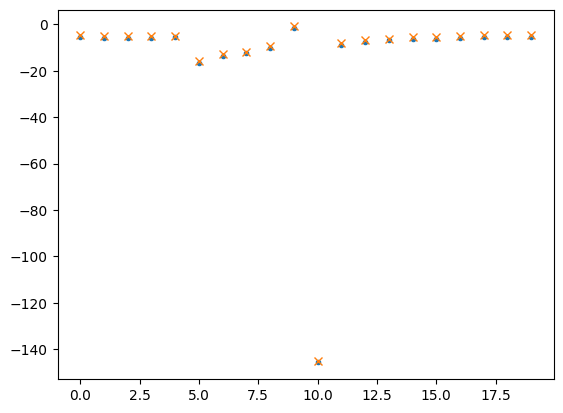

In [ ]:
gamma1 = []
gamma1_asymp = []
for i,niw in enumerate(niws[-1:]):
    plt.plot(gamma_m_all[i], ".")
    plt.plot(gamma_m_all_asymp[i], "x")
    #gamma1.append(gamma_m_all[i][10])
    #gamma1_asymp.append(gamma_m_all_asymp[i][10])

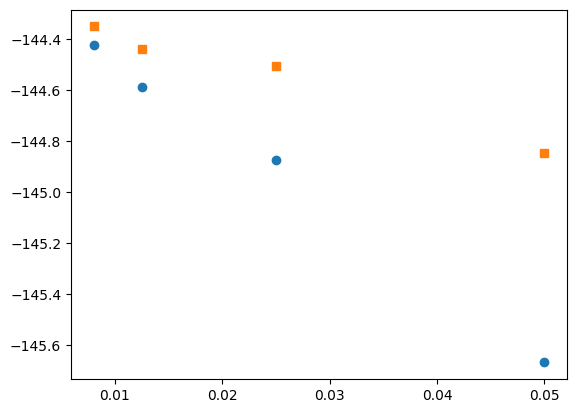

In [ ]:
plt.plot(1/np.array(niws), gamma1, "o")
plt.plot(1/np.array(niws), gamma1_asymp, "s")

### nonlocal asymp

### calculate lattice chi_q

In [ ]:
chi0_w = bse.chi0_loc_w(beta, g, n4iwf, n4iwb)

# kgrid has to be initialized beforehand
kpoints = np.linspace(-np.pi,np.pi,48,endpoint=False)
k_grid = np.meshgrid(kpoints,kpoints)
k_grid = np.array(k_grid).reshape(2,-1).T

chi0_q_w = bse.chi0_w_q(beta, mu, s, k_grid, np.array([[0.,0.]]), n4iwf, n4iwb)
print(chi0_q_w.shape)

#u = U*np.ones([2*n4iwb+1], dtype=np.float64)
data = bse.chi_v_r_w_q(beta, U, w0, g0, chi0_w, chi0_w.reshape(*chi0_w.shape,1), g2, n4iwf, n4iwb, qpoints=np.array([[0.,0.]]))

(250, 101, 1)


(250, 101, 1)


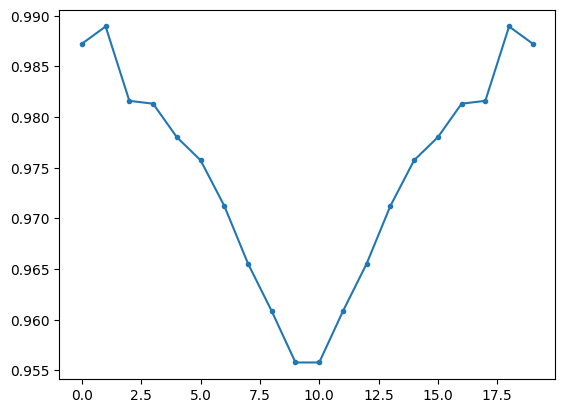

In [ ]:
import matplotlib.pyplot as plt

chi = data[4]
print(chi.shape)

plt.plot(chi[125-10:125+10,50,0], ".-")

In [ ]:
F_d, F_m = bse.F_r_loc(beta, chi0_w, g2, n4iwf, n4iwb)

print(F_d.shape)

(260, 260, 41)


In [ ]:
F_uu = 0.5*(F_d+F_m)

print(F_uu.shape)

F_uu_1 = F_uu[130+72,130+70,5]

F_uu_2 = -F_uu[130+72,130+72,3]

print(F_uu_1, F_uu_2)

(260, 260, 41)
(-3.2809342308280964-19.95673701439307j) (-70.86419608938215-23.3668316656763j)


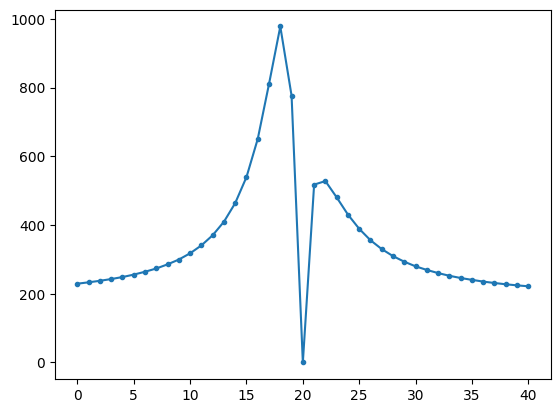

In [ ]:
plt.plot(F_uu[130,130, :], ".-")

In [ ]:
chi0 = bse.

(2000,)